# Global warming simulator

The following code simulates the time-dependent global warming due to a strengthening greenhouse effect caused by human emissions of greenhouse gases. The current version of the model emits the effect of the greenhouse effect on the equilibrium climate and so. You can swap out the parameter $B$ for a smaller gray-gas value for a better estimate of the model's sensitivity to radiative forcing. The code will hopefully soon be expanded to include a deep-ocean reservoir for heat, roughly following Held et al. 2009 (https://journals.ametsoc.org/doi/full/10.1175/2009JCLI3466.1).

In [1]:
using Unitful
using PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1242
┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /Users/hdrake/.julia/packages/PyCall/ttONZ/src/PyCall.jl:705
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda /Users/hdrake/.julia/packages/Conda/kLXeC/src/Conda.jl:112


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/hdrake/.julia/conda/3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.10.0              |           py37_0          14 KB
    freetype-2.9.1             |       hb4e5f40_0         555 KB
    kiwisolver-1.1.0           |   py37h0a44026_0          54 KB
    libpng-1.6.37              |       ha441bb4_0         262 KB
    matplotlib-3.1.1           |   py37h54f8f79_0         4.9 MB
    pyparsing-2.4.2            |             py_0          61 KB
    pytz-2019.2                |             py_0         245 KB
    ------------------------------------------------------------
                                           Total:         6.1 MB

The following NEW packages will be INSTALLED:

  cycler             pkgs/main/osx-64::cycler-0.10.0-py37_0
  fr

┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/hdrake/.julia/packages/PyPlot/4wzW1/src/init.jl:118
┌ Info: Installing PyQt5 via the Conda pyqt package...
└ @ PyCall /Users/hdrake/.julia/packages/PyCall/ttONZ/src/PyCall.jl:705
┌ Info: Running `conda install -y pyqt` in root environment
└ @ Conda /Users/hdrake/.julia/packages/Conda/kLXeC/src/Conda.jl:112


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/hdrake/.julia/conda/3

  added / updated specs:
    - pyqt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dbus-1.13.6                |       h90a0687_0         445 KB
    expat-2.2.6                |       h0a44026_0         111 KB
    gettext-0.19.8.1           |       h15daf44_3         2.6 MB
    glib-2.56.2                |       hd9629dc_0         3.7 MB
    icu-58.2                   |       h4b95b61_1        10.1 MB
    jpeg-9b                    |       he5867d9_2         201 KB
    pcre-8.43                  |       h0a44026_0         185 KB
    pyqt-5.9.2                 |   py37h655552a_2         3.6 MB
    qt-5.9.7                   |       h468cd18_1        62.0 MB
    sip-4.19.8                 |   py37h0a44026_0         237 KB
    -------------------------------------------------

Consider the "Rock-Star" zero-dimensional system from Michael Mann's Module 3.4 in which the solar radiation absorbed by Earth is balanced by its thermal radiation (giving by the Stefan-Boltzmann) relationship:
\begin{equation}
c_{f} \frac{\text{d}T}{\text{d}t} = \frac{S(1-\alpha)}{4} - \sigma T^{4} + F(t)
\end{equation}
where $\alpha=0.32$ is the albedo, $\sigma$ is the Stefan-Boltzmann constant, $T=255\text{ K}$ is the average surface temperature of Earth, $S=1360\text{ W/m}^{2}$ is the Solar Constant, and $c_{f}$ is the effective heat capacity per unit area of the Earth, and $F(t)$ is the greenhouse effect due to increasing greenhouse gas emissions (such as carbon dioxide CO$_{2}$ and methane CH$_{4}$).

We approximate the "business as usual" or "worst case" future emissions scenario known as RCP8.5 (meaning an increase in radiative forcing of $8.5\text{ W/m}^{2}$) by the linear function $F(t)=\frac{8.5 \text{ W/m}^{2}}{100 \text{ years}} (t-t_{0}) H(t-t_{0})$, where $H(x)$ is the heavyside funciton, which is zero until $t=t_{0}$ and then increases from $F(t_{0})=0$ at $t_{0}=2000\text{ CE}$ to $F(t_{final})=8.5\text{ W/m}^{2}$ at $t_{0}=2100\text{ CE}$.

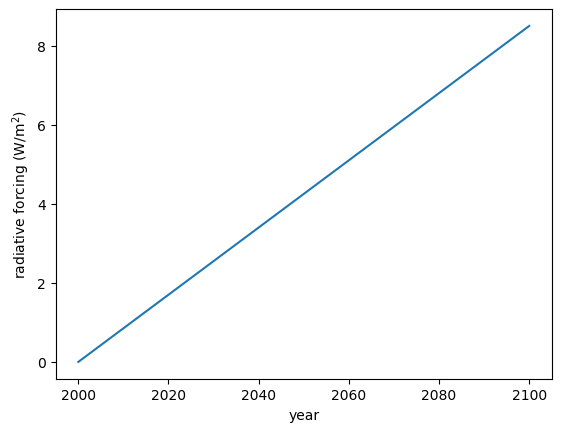

In [145]:
sec_in_year = (365. * 24. * 60. * 60.)u"s"
t0 = (2000. * sec_in_year); # initial condition in 2000
Δt = (24. * 60. * 60.)u"s"; # 1 day time step
t = t0:Δt:(t0+Δt * 100. * 365.); # time array from 2000 to 2100

Ffinal = 8.5u"W/m^2";
F = Ffinal / (100. * sec_in_year) * (t .- t0) # radiative forcing due to greenhouse effect

# Make plot of radiative forcing
plot(t/sec_in_year,ustrip.(F))
xlabel("year")
ylabel(L"radiative forcing (W/m$^{2}$)");

Since the surface of the planet is mostly covered by oceans, a good first approximation for Earth's heat capacity is the heat capacity of the upper $100$ m of the ocean which are constantly mixed and efficiently exchange heat with the atmosphere. The heat capacity of this layer is given by $c_{f} = c_{p}\rho H$ where $c_{p} = 1$ is the specific heat capacity of water, $\rho = 1000 \text{ kg/m}^{3}$ is the density of water, and $H=100 \text{ m}$ is the thickness of the surface mixed layer.

In [146]:
H = 100u"m"; # depth of surface ocean mixed layer
ρ = 1000u"kg/m^3"; # density of liquid water 
c_p = 4180.0u"J/kg/K"; # specific heat capacity of liquid  water

c_f = c_p * ρ * H # upper ocean heat capacity

4.18e8 J K^-1 m^-2

For simplicity, we linearize the system around $t_{0}$, i.e. approximating $\sigma T^{4} \approx A + B(T-T_{0})$:

\begin{equation}
c_{f} \frac{\text{d}T}{\text{d}t} = \frac{S(1-\alpha)}{4} - A - B(T-T_{0}) + F(t)
\end{equation}

If we assume the system is at equilibrium before $t=t_{0}$, then we have simply
\begin{equation}
0=\frac{S(1-\alpha)}{4} - A
\end{equation}

If we then define $T'=T-T_{0}$ as the temperature *anomaly*, we have the simplified linear system for the evolution of the temperature anomaly:
\begin{equation}
c_{f} \frac{\text{d}T'}{\text{d}t} = - BT' + F(t)
\end{equation}

The linear coefficient $B$ is given by the derivative of $\sigma T^{4}$ with respect to $T$ evaluated at $T=T_{0}$,
\begin{equation}
B=4\sigma T_{0}^3
\end{equation}

In [148]:
T0 = 255u"K"; # equilibrium temperature 
σ = 5.67e-8u"W/m^2/K^4"; # Stefan-Boltzmann constant
B = 4 * σ  * (T0)^3; # derivative of outgoing flux to space with respect to T

# A simple numerical solver

To solve the following equation, 

\begin{equation}
c_{f} \frac{\text{d}T'}{\text{d}t} = -B T' + F(t)
\end{equation}
with initial condition $T'=0\text{ K}$.

we discretize using forward finite differences:
\begin{equation}
c_{f} \frac{T'_{k+1} - T'_{k}}{\Delta t}=  F_{k} - T'_{k}B
\end{equation}

which we rewrite in terms of the future temperature $T'_{k+1}$ as
\begin{equation}
T'_{k+1} = T'_{k} + \Delta t \left(\frac{F_{k}}{c_{f}} - T'_{k} \frac{B}{c_{f}}\right)
\end{equation}

In [131]:
T=zeros(size(t))u"K" # initial condition

for k=1:length(t)-1
    T[k+1] = T[k] .+ Δt .* (F[k]./c_f .- T[k]*B/c_f)
end

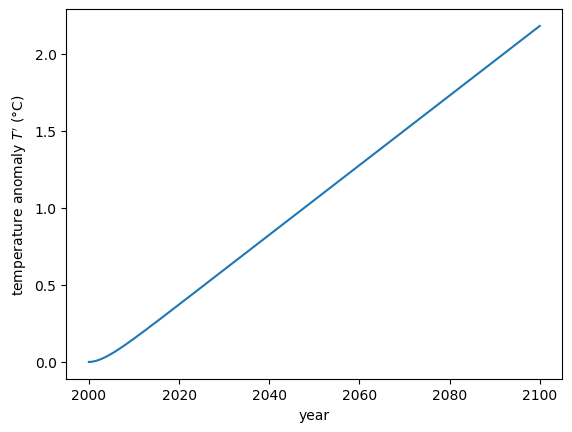

In [150]:
plot(t/sec_in_year,ustrip.(T))
xlabel("year")
ylabel(L"temperature anomaly $T'$ ($\degree$C)");